# 24S2 SC3000/CZ3005 Assignment 1: Balancing a Pole on a Cart

## Contributions

| Name                    | Matriculation Number | Group | Contribution    |
|-------------------------|----------------------|-------|-----------------|
| Kent Karsten Pangestu   |                      | SCS4  | Task 1, 2, 3, 4 |
| Lee Heng Sheng, Brandon | U2322900C            | SCSX  | Task 1, 2, 3, 4 |
| Alan Lee Leman          | U2321753B            | SCSX  | Task 1, 2, 3, 4 |

## Installing Dependencies

You may find the list of dependencies in the requirements.txt file. We recommend activating a virtual environment before installing the required dependencies to prevent conflicting versions of dependencies (especially because we're using an older version of NumPy).

### Conda (If required)

**Note that because Python is not forward compatible, NumPy==1.26.4 does not support the latest Python version (3.13.X at this moment). If you have an older, compatible version of Python, you do not need to use Conda.** You may check your Python version by running `python --version`.

However, if you encounter issues with installation of modules due to incompatible python versions, we recommend installing a package manager like [Conda](https://docs.conda.io/projects/conda/en/latest/user-guide/install/index.html) to create an environment with an older verison of Python. Ensure that Conda/Anaconda is added to your PATH variable. You may check this by running `conda --version`.


1. Create an environment with an older Python version.

```
conda create -n myenv python=3.12.9
conda activate myenv
```

You can also check that the Python version in the environment is correct by running `python --version`.

2. Navigate to the directory with requirements.txt and install the required dependencies. You do not need to activate venv if you are already using Conda.

```
pip install -r requirements.txt
```

### Windows (Terminal)

#### 1. Create a virtual environment.

```
python -m venv env
```

#### 2. Activate the virtual environment.

```
.\env\Scripts\activate
```

Alternatively, if the above does not work,

```
.\env\Scripts\activate.bat
```

If you encounter permission problems, you may need to run the following command to allow the script to run:

```
Set-ExecutionPolicy RemoteSigned -Scope CurrentUser
```

#### 3. Navigate to the directory with requirements.txt and install the required dependencies.

```
pip install -r requirements.txt
```

### Linux/MacOS

#### 1. Create a virtual environment.

```
python -m venv env
```

#### 2. Activate the virtual environment.

```
source env/bin/activate
```

#### 3. Navigate to the directory with requirements.txt and install the required dependencies.

```
pip install -r requirements.txt
```

## Running Code

If you are using JupyterLab, you need to launch the jupyterlab instance **within** the virtual environment for the code to run within the virtual environment. 

While your virtual environment is active, run

```
jupyter lab
```

If you are using Conda and already have the environment activated, you may directly run `jupyter lab`. 

## Importing Dependencies

In [1]:
import gym
import base64
import glob
import io
from IPython import display as ipythondisplay
from IPython.display import HTML
from gym.wrappers import RecordVideo
import base64
from gym import logger as gymlogger
from collections import defaultdict
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from abc import ABC, abstractmethod

# CartPole Environment

In [2]:
env = gym.make("CartPole-v1")

print(f"Action Space: {env.action_space}")
print(f"Observation Space: {env.observation_space}")

Action Space: Discrete(2)
Observation Space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


### Action Space
The action space takes discrete values of either **0** or **1**, pushing the cart to the left or right respectively.

### Observation Space
The observation space takes continuous values, summarised in the table below.

<table style="width:70%; font-size: 14px; border: 1px solid black; border-collapse: collapse;">
  <tr>
    <th>Num</th>
    <th>Observation</th>
    <th>Min</th>
    <th>Max</th>
  </tr>
  <tr>
    <td>0</td>
    <td>Cart Position</td>
    <td>-4.8</td>
    <td>4.8</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Cart Velocity</td>
    <td>-Inf</td>
    <td>Inf</td>
  </tr>
  <tr>
    <td>2</td>
    <td>Pole Angle</td>
    <td>~ -0.418 rad (-24°)</td>
    <td>~ 0.418 rad (24°)</td>
  </tr>
  <tr>
    <td>3</td>
    <td>Pole Angular Velocity</td>
    <td>-Inf</td>
    <td>Inf</td>
  </tr>
</table>

### Reward
Since the goal is to keep the pole upright for as long as possible, a reward of **+1** for every step taken, including the termination step, is allotted.


### Starting State
All observations are assigned a uniformly random value in (-0.05, 0.05).

### Terminating Conditions
An episode ends if any one of the following occurs:

* Pole Angle is greater than ±12°

* Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)

* Episode length is greater than 500


## Task 1:  Development of an RL Agent

Since all 4 observed values in the observation space are continuous, we need to discretise them into bins. 

* `cart_position` is split into **4** bins with intervals of **2.5**
* `cart_velocity` is split into **4** bins with intervals of **2.5** 
* `pole_angle` is split into **10** bins with intervals of **0.1** 
* `pole_angular_velocity` is split into **40** bins with intervals of **0.25**

Through trial and error, we found that `pole_angular_velocity` is the most important factor in the learning growth, followed by `pole_angle`. Hence, they are set with relatively more bins to account for more precise changes.

We created a base class comprising of basic attributes and methods to describe what an agent should have and do.

In [3]:
class Agent(ABC):
    def __init__(self, env, discount_factor = 0.99, epsilon = 1.0, epsilon_decay = 0.9995, epsilon_min = 0.07) -> None:
        self.env = env
        self.discount_factor = discount_factor # γ
        self.epsilon = epsilon # ϵ
        self.epsilon_decay = epsilon_decay 
        self.epsilon_min = epsilon_min 
        self.observation = [4, 4, 10, 40] # Number of bins set for each variable in an observation
        self.window_size = np.array([2.5, 2.5, 0.1, 0.25]) # Size of each bin
        self.q_table = np.random.uniform(low = 0, high = 1, size = (self.observation + [env.action_space.n])) 
    
    def discretise_state(self, state) -> tuple:
        """
        Converts a continuous state into its discrete values.

        Returns a tuple of discrete values describing a state.
        """
        discrete_state = state/self.window_size + np.array([2,2,5,20]) # Normalise the state values to prevent negative indexing 
        return tuple(discrete_state.astype(int)) # Truncate and convert to tuple to use as a key in the Q-table
    
    def decay_epsilon(self) -> None:
        """Decays the exploration factor (epsilon) after each episode."""
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

    def policy(self, state) -> int:
        """
        Rule to determine which action to take at a particular state, with noise added to encourage exploration.
        
        Returns an action as either 0 or 1.
        """
        if np.random.rand() < self.epsilon: # Probability of ϵ to explore
            return self.env.action_space.sample()
        else: # Probability of 1 - ϵ to exploit
            return np.argmax(self.q_table[state]) 

    @abstractmethod
    def generate_episode(self) -> int:
        """
        Generates an episode and updates the Q-values by calling update_q_table.

        (Algorithm dependent)

        Returns the cumulative reward for one episode.
        """
        pass

    @abstractmethod
    def update_q_table(self, episode) -> None:
        """Updates the Q-values in the Q-table attribute using an update rule.

        (Algorithm dependent)

        """
        pass

    def train_episodes(self, num_episodes) -> None:
        """Runs the agent through multiple episodes to learn from the environment."""
        reward = 0 
        for episode in range(1,num_episodes+2):
            reward += self.generate_episode()
            self.decay_epsilon() # Decay epsilon after each episode
            if episode % 1000 == 0:
                print(f"Mean reward for the first {episode} episodes: {reward/1000}")
                reward = 0
   
    def run(self, raw_state) -> int:
        """
        Determines the best possible action based on current Q-values.
        
        Returns an action of either 0 or 1.
        """
        state = self.discretise_state(raw_state)
        action = np.argmax(self.q_table[state])
        return action
    
    def test_episodes(self, num_episodes) -> list:
        """
        Tests the agent's performance based on current Q-values through multiple episodes.
        
        Returns a list of the cumulative rewards over num_episodes."""
        reward_list = []

        for episode in range(num_episodes):
            state, _ = self.env.reset()
            done = False
            cumulative_reward = 0

            while not done:
                action = self.run(state)
                next_state, reward, done, _, _ = self.env.step(action)
                cumulative_reward += reward
                if cumulative_reward > 499:
                    break
                state = next_state
                
            reward_list.append(cumulative_reward)
            
        return reward_list
    

The Q-table of an agent is a 5-dimensional tensor, where

1st dimension: cart position; `len(q_table)` == 4, storing the 4 possible discrete states of cart_position

2nd dimension: cart velocity; `len(q_table[0])` == 4, storing the 4 possible discrete states of cart_velocity

3rd dimension: pole angle; `len(q_table[0][0])` == 10, storing the 10 possible discrete states of pole_angle

4rd dimension: pole angular velocity; `len(q_table[0][0][0])` == 40, storing the 40 possible discrete states of pole_angular_velocity

5th dimension: action; `len(q_table[0][0][0][0])` == 2, storing either 0 or 1

Each entry in the 5D tensor is initialised with arbitrary values from **0** to **1** using `np.random.uniform()`.

We determined that exploration is much more important than exploitation in this context due to the large state space. Hence, the hyperparameters are adjusted to accommodate exploration over exploitation in the beginning stages. More specifically,

* `discount_factor γ` determines the importance of future rewards when evaluating the expected returns from a state-action pair. It is set at **0.99** to prioritise long-term rewards, encouraging the agent to learn strategies that optimise the overall return rather than focusing only on immediate rewards.

* `epsilon ϵ` adds noise to allow the agent to explore other actions besides the current best-known action at a given state. It is set at **1** to encourage complete exploration early on when it has little knowledge of the environment, which is especially important in large state spaces.

* `epsilon_decay` decreases ϵ over time. It is set at **0.9995** to gradually transition to exploitation over exploration as the agent gains more knowledge and becomes more confident in its decisions.

* `epsilon_min` sets a minimum threshold allowed for ϵ. It is set at **0.07** to ensure that the agent keeps exploring even at the later stages, preventing overly greedy actions that only satisfies a local optima.


### 1a. Monte-Carlo Control

We implemented the Monte-Carlo Control algorithm as outlined below.

![alt text](mc_algorithm.png)

In [4]:
class Monte_Carlo(Agent):
    def __init__(self, env) -> None:
        super().__init__(env)
        self.returns = defaultdict(int)
        self.visits = defaultdict(int)

    def generate_episode(self) -> int:
        episode = []
        state, _ = self.env.reset() # Environment is reset at the beginning of each episode
        state = self.discretise_state(state)
        done = False
        cumulative_reward = 0
        
        while not done:
            action = self.policy(state) 
            next_state, reward, done, _, _ = self.env.step(action)
            episode.append((state, action, reward)) # The entire trajectory of an episode is stored in an array
            state = self.discretise_state(next_state)
            cumulative_reward += reward

            if cumulative_reward > 499:
                break

        self.update_q_table(episode) # Q-table is updated per episode

        return cumulative_reward
    
    def update_q_table(self, episode) -> None:
        G = 0
        state_action_visited = defaultdict(int)

        # Iterate trough a trajectory backwards 
        for i in reversed(range(len(episode))):
            state, action, reward = episode[i]
            G = reward + self.discount_factor * G # Calculate G using G(t) = r(t) + γ * G(t+1)
            state_action_visited[(state, action)] = G # Computes returns using first-visit MC method

            for (state, action), val in state_action_visited.items():
                self.returns[(state, action)] += val # val is the value of G for a given state-action pair
                self.visits[(state, action)] += 1
                self.q_table[state + (action,)] = self.returns[(state, action)] / self.visits[(state, action)] # Update Q table for each state-action pair

In Monte-Carlo, the entire trajectory of an episode is stored, and the Q-table is updated according to the trajectory after an episode is finished. A first-visit method is used to ensure a state-action pair is only updated once per episode. 

G is calculated using
$$G_t = R_t + \gamma R_{t+1}  + γ^2R_{t+2} + ... + \gamma ^nR_{t+n} = R_t + \gamma G_{t+1}$$ 

and Q(s,a) is updated using 
$$Q(state,action) = \frac{Total Returns}{Total Count}$$

The agent is then trained on 5000 episodes, and the average reward every 1000 episodes is indicated to highlight the agent's progress.

In [5]:
Monte_Carlo_Agent = Monte_Carlo(env)
Monte_Carlo_Agent.train_episodes(5000)

Mean reward for the first 1000 episodes: 43.276
Mean reward for the first 2000 episodes: 206.224
Mean reward for the first 3000 episodes: 415.735
Mean reward for the first 4000 episodes: 485.823
Mean reward for the first 5000 episodes: 498.047


Sampling a random state from the cart pole environment to the agent:

In [6]:
state, _ = env.reset()
action = Monte_Carlo_Agent.run(state)
print("Observation:", state)
print("Chosen action:", action)

Observation: [ 0.02218256 -0.00248459 -0.01519187 -0.009676  ]
Chosen action: 0


### 1b. Q-Learning

We also implemented the Q-Learning algorithm as outlined below.

<img src="q_learning_algorithm.png" width="800" height="340">

We added an extra hyperparameter `learning_rate α`, which is needed in a Q-Learning algorithm.

* `learning_rate α` controls how much the Q-values are updated in each step of an episode. It is set low at **0.1** to allow for more stability during the training process by ensuring that the agent learns more gradually.


In [7]:
class QLearning(Agent):
    def __init__(self, env, learning_rate=0.1):
        super().__init__(env)
        self.learning_rate = learning_rate # α
        
    def generate_episode(self) -> int:
        state, _ = self.env.reset() # Environment is reset at the beginning of each episode
        state = self.discretise_state(state)
        done = False
        cumulative_reward = 0

        while not done:
            action = self.policy(state)
            next_state, reward, done, _, _ = self.env.step(action)
            next_state = self.discretise_state(next_state)
            cumulative_reward += reward

            if cumulative_reward > 499:
                break
            
            self.update_q_table(state, next_state, action, reward) # Q-table is updated per action taken
            state = next_state

        return cumulative_reward

    def update_q_table(self, state, next_state, action, reward) -> None:
        current_q = self.q_table[state + (action,)]
        next_max_q = np.max(self.q_table[next_state])
        
        # Update Q-value using the Bellman equation: Q(s, a) = (1 - α) * Q(s, a) + α * (r + γ * max_a(Q(s', a')))
        new_q = (1 - self.learning_rate) * current_q + self.learning_rate * (reward + self.discount_factor * next_max_q)
        self.q_table[state + (action,)] = new_q

In Q-Learning, the Q-table is updated for each action taken between states according to 

$$
Q_{\text{new}}(s_t, a_t) = (1-\alpha) Q_{\text{old}}(s_t,a_t) + \alpha (Reward_{t+1} + \gamma \max_a Q_{\text{old}}(s_{t+1},a))
$$

Thus, there is no need to store the trajectory of an episode.

The agent is then trained on 5000 episodes, and the average reward every 1000 episodes is indicated to highlight the agent's progress.

In [8]:
Q_agent = QLearning(env)
Q_agent.train_episodes(5000)

Mean reward for the first 1000 episodes: 29.786
Mean reward for the first 2000 episodes: 162.84
Mean reward for the first 3000 episodes: 311.885
Mean reward for the first 4000 episodes: 408.765
Mean reward for the first 5000 episodes: 453.574


Sampling a random state from the cart pole environment to the agent:

In [9]:
state, _ = env.reset()
action = Q_agent.run(state)
print("Observation:", state)
print("Chosen action:", action)

Observation: [0.00947912 0.03626118 0.02548729 0.01538281]
Chosen action: 1


### Note

We noted that the performance of an RL agent may vary in different training environments.

This is because an agent may develop a bias towards a suboptimal strategy where it continuously moves in one direction to keep the pole balanced. While this strategy successfully prevents the pole from falling, it can lead to early termination of an episode when the cart exceeds the allowed position limits of ± 2.4. Since the reward function incentivises pole balance without explicitly discouraging excessive lateral movement, the agent may not learn to keep the cart centred and consequently may drift away to the boundary. This results in mean rewards that converges more slowly to 500 since episodes end prematurely despite the pole remaining upright.

In such a scenario, more number of episodes may be needed to converge to an optimal policy. However, for our case, we think that 5000 episodes are good enough to train an agent for this task.

## Task 2: Demonstrate the effectiveness of the RL agent

### 2a. Performance of Monte-Carlo Control agent

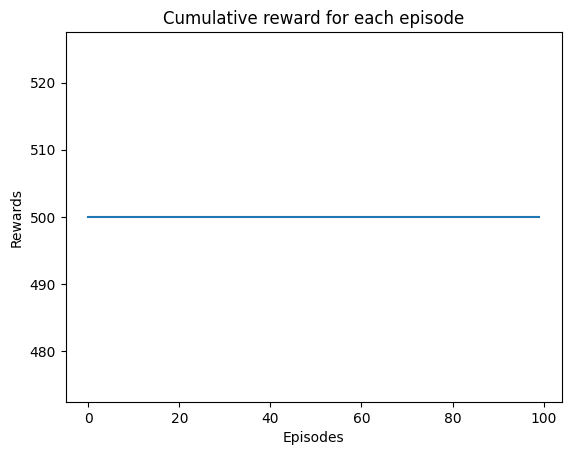

Average cumulative reward: 500.0
Is my agent good enough? True


In [10]:
episode_results = Monte_Carlo_Agent.test_episodes(100)

plt.plot(episode_results)
plt.title("Cumulative reward for each episode")
plt.ylabel('Rewards')
plt.xlabel('Episodes')
plt.show()

print("Average cumulative reward:", np.mean(episode_results))
print("Is my agent good enough?", np.mean(episode_results) > 195)

### 2b. Performance of Q-Learning agent

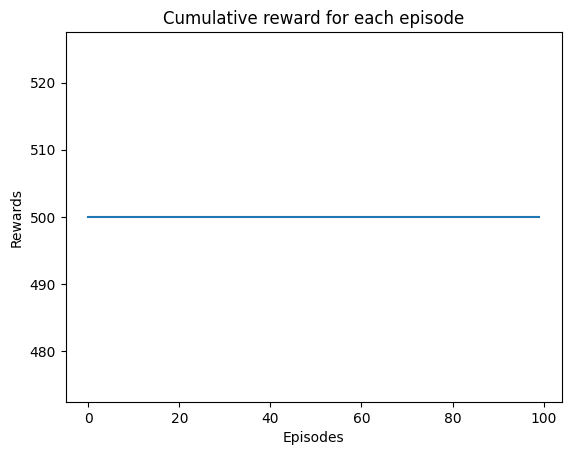

Average cumulative reward: 500.0
Is my agent good enough? True


In [11]:
episode_results = Q_agent.test_episodes(100)

plt.plot(episode_results)
plt.title("Cumulative reward for each episode")
plt.ylabel('Rewards')
plt.xlabel('Episodes')
plt.show()

print("Average cumulative reward:", np.mean(episode_results))
print("Is my agent good enough?", np.mean(episode_results) > 195)

Although both agents are able to practically solve the game within 5000 episodes, the Q-Learning agent may be the more memory-efficient agent since unlike in Monte-Carlo, its bootstrapping strategy does not require it to keep track of the entire history of an episode.

## Task 3: Render one episode played by the agent

We will choose the Monte Carlo agent for this task.

In [15]:
def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'rb').read()
        encoded = base64.b64encode(video).decode('ascii')
        display(HTML(f'<video width="600" controls><source src="data:video/mp4;base64,{encoded}" type="video/mp4"></video>'))
    else:
        print("Could not find video")

def videoEpisode(agent):
    env = RecordVideo(gym.make('CartPole-v1', render_mode='rgb_array'), "./video")
    state, _ = env.reset()
    done = False
    while not done:
        action = agent.run(state)
        next_state, reward, done, _, _ = env.step(action)
        state = next_state
    env.close()
    show_video()
    return

videoEpisode(Monte_Carlo_Agent)

MoviePy - Building video C:\Users\brand\Documents\Notes\SC3000\SC3000\video\rl-video-episode-0.mp4.
MoviePy - Writing video C:\Users\brand\Documents\Notes\SC3000\SC3000\video\rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\brand\Documents\Notes\SC3000\SC3000\video\rl-video-episode-0.mp4


## Task 4
### Format the Jupyter notebook by including step-by-step instruction and explanation, such that the notebook is easy to follow and run (refer to the tutorial section in the sample notebook). Include text explanation to demonstrate the originality of your implementation and your understanding of the code. 

Done.